In [8]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import mlflow
import mlflow.sklearn
mlflow.set_tracking_uri("http://127.0.0.1:5000")


# Global random state (define early so helper functions can use it)
RANDOM_STATE = 42

# Make plots inline (for notebooks)
%matplotlib inline

In [9]:
def make_fake_data(n=1000, n_features=5, noise=0.1, random_state=None):
    # Use the global RANDOM_STATE if no explicit random_state is provided
    if random_state is None:
        rng = np.random.default_rng(RANDOM_STATE)
    else:
        rng = np.random.default_rng(random_state)
    X = rng.normal(size=(n, n_features))
    true_coef = rng.normal(size=n_features)
    y = X.dot(true_coef) + rng.normal(scale=noise, size=n)
    return X, y

In [10]:
# Experiment / data parameters
EXPERIMENT_NAME = "nyc_taxi_mlops_experiment"
N_SAMPLES = 1000
N_FEATURES = 5
NOISE = 0.5
RANDOM_STATE = 42

# Create data
# use the global RANDOM_STATE via make_fake_data's default
X, y = make_fake_data(n=N_SAMPLES, n_features=N_FEATURES, noise=NOISE)
print('X shape:', X.shape)
print('y shape:', y.shape)

# Quick peek
X[:3], y[:3]

X shape: (1000, 5)
y shape: (1000,)


(array([[ 0.30471708, -1.03998411,  0.7504512 ,  0.94056472, -1.95103519],
        [-1.30217951,  0.1278404 , -0.31624259, -0.01680116, -0.85304393],
        [ 0.87939797,  0.77779194,  0.0660307 ,  1.12724121,  0.46750934]]),
 array([-1.140063  , -0.51519844,  0.29926393]))

In [11]:
# Train/validation split
# use the global RANDOM_STATE for reproducible splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print('X_train', X_train.shape, 'X_val', X_val.shape)
print('y_train', y_train.shape, 'y_val', y_val.shape)

X_train (800, 5) X_val (200, 5)
y_train (800,) y_val (200,)


In [12]:
# Start an MLflow run, train and log model
mlflow.set_experiment(EXPERIMENT_NAME)
with mlflow.start_run(run_name="fake data_fit_intercept True") as run:
    params = {
        'n_samples': X.shape[0],
        'n_features': X.shape[1],
        'noise': NOISE
    }
    mlflow.log_params(params)

    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)
    mlflow.log_metric('rmse', float(rmse))

    # Log model artifact to the run
    mlflow.sklearn.log_model(model, 'model')

    print(f'Run {run.info.run_id} logged with RMSE = {rmse:.4f}')
    # expose variables for later cells
    trained_model = model
    run_id = run.info.run_id

2025/12/20 10:49:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/20 10:49:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Run 4d9b1893e401485187b9e5bd022a6ba4 logged with RMSE = 0.4991
🏃 View run fake data_fit_intercept True at: http://127.0.0.1:5000/#/experiments/1/runs/4d9b1893e401485187b9e5bd022a6ba4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [13]:
# Inspect trained model and coefficients
try:
    coef = trained_model.coef_
    intercept = trained_model.intercept_
    print('Intercept:', intercept)
    print('Coefficients:', coef)
except NameError:
    print('`trained_model` not defined. Run the training cell above.')

Intercept: 0.028565455854233507
Coefficients: [-0.29778783 -0.3200832  -0.69621993  0.43167871  0.20693458]


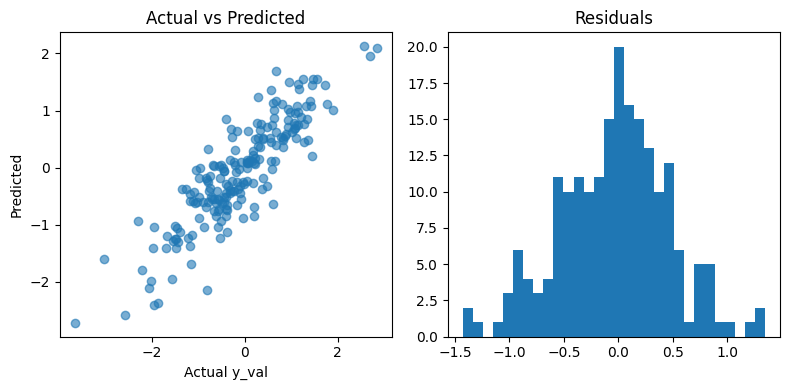

In [14]:
# Visualize predictions vs actuals and residuals
try:
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.scatter(y_val, preds, alpha=0.6)
    plt.xlabel('Actual y_val')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')

    plt.subplot(1,2,2)
    res = y_val - preds
    plt.hist(res, bins=30)
    plt.title('Residuals')
    plt.tight_layout()
    plt.show()
except NameError:
    print('`preds` or `y_val` not available. Run the training cell first.')

**Notes**:
- MLflow stores runs under the local `mlruns/` directory by default.
- To inspect runs interactively, run `mlflow ui` in the project root and open http://localhost:5000.
- You can re-run individual cells to tweak data, noise, or model and re-log runs.